# Lab 3: Data Cleaning and Visualization
### Instructions

In this lab, you will be working with a dataset from NYPD containing data on calls to the New York Police Department. Information about the datasets can be found https://opendata.cityofnewyork.us/

## Setup

Note that after activating matplotlib to display figures inline via the IPython magic `%matplotlib inline`, we configure a custom default figure size. Virtually every default aspect of matplotlib [can be customized](https://matplotlib.org/users/customizing.html).

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# Part 1:Getting Data

We will work with the NYPD Historic complaint data set. Our first task is to estimate the size of this download by looking at the number of rows, columns and using an estimated size for a column (use a reasonable value). The site metadata is available from the page
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

In [2]:
#estimated size of the download (based on metadata information from the site)  = 2085MB
# 
# To calculate the data size is (N*V*W +4*N)/1024^2
# N= number of rows
# V = number of columns
# Average width in bytes of a columns
#(6500000 * 35 * 9.5 + 4*6500000)/1024^2 = 2085 MB


### 1.1 Download the data
This file is large (use the estimate you did above). If it takes too long to download, you may want to interrupt and download the file using a browser and URL https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

In [3]:
import utils
data_dir = 'data'
data_url = 'https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i'

file_name = 'NYPD_Complaint_Data_Historic.csv'

# To retrieve the dataset, we will use the `utils.fetch_and_cache` utility from utils library. 
dest_path = utils.fetch_and_cache(data_url=data_url, file=file_name,data_dir=data_dir)
print(f'Located at {dest_path}')

Using version already downloaded: Fri Oct 11 19:31:43 2019
MD5 hash of file: 5f6acf3113970cc1506d63ab6a20daa1
Located at data/NYPD_Complaint_Data_Historic.csv


### 1.2 Inspect the size of the file
It is helpful to get an idea of the size of the file. This can be done using functions in the utils library.

In [4]:
# look at the size of the file w/o opening it using OS (https://docs.python.org/3/library/os.html). You can perform
# variety of operating system related functions from this package.
#!ls -lh data/

import os
os.path.getsize('data/NYPD_Complaint_Data_Historic.csv')


2052178815

### 1.3 Split the large file
This data file NYPD_Complaint_Data_Historic.csv is too big to load into a single DataFrame. Let us split the large file into smaller files.  Let us find out the number of lines in the NYPD_Complaint_Data_Historic.csv file using utils.

In [5]:
# Using utils library, find the number of lines in the file

utils.line_count('data/NYPD_Complaint_Data_Historic.csv')


6500871

In [6]:
# Split the file into 10 smaller files. Estimate the number of lines in each file using the count above
# files should be created in the data folder and named NYPD_Complaint_Data_Historic_1.csv, 
# NYPD_Complaint_Data_Historic_2.csv, ... NYPD_Complaint_Data_Historic_10.csv etc
# It is possible that few lines from the original file may not be saved due to rounding errors.

total_lineno = utils.line_count('data/NYPD_Complaint_Data_Historic.csv')
chunk_size = total_lineno //10


fout = None
with open('data/NYPD_Complaint_Data_Historic.csv') as bigfile:
    for i, line in enumerate(bigfile):
        if i % chunk_size ==0:
            if fout: fout.close()
         
            fout = 'data/NYPD_Complaint_Data_Historic_{}.csv'.format(i//chunk_size +1)
            fout = open(fout, "w")
        fout.write(line)
    fout.close()

### 1.4 Check the files in the data folder
Now, we'll use a method of the `Pathlib.Path` class called `glob` to list all files in the `data` directory. You will find useful information in pathlib [docs](https://docs.python.org/3/library/pathlib.html).

Below, we use pathlib's `glob` method to store the list of all files' names from the `data_dir` directory in the variable `file_names`. These names should be strings that contain only the file name (e.g. `dummy.txt` not `data/dummy.txt`). The asterisk (*) character is used with the `glob` method to match any string.

In [7]:
from pathlib import Path
data_dir_path = Path('data') # creates a Path object that points to the data directory
file_names = [x.name for x in data_dir_path.glob('*') if x.is_file()]
file_names

['NYPD_Complaint_Data_Historic_10.csv',
 'NYPD_Complaint_Data_Historic_11.csv',
 '.DS_Store',
 'NYPD_Complaint_Data_Historic_7.csv',
 'NYPD_Complaint_Data_Historic_6.csv',
 'NYPD_Complaint_Data_Historic.csv',
 'NYPD_Complaint_Data_Historic_4.csv',
 'NYPD_Complaint_Data_Historic_5.csv',
 'NYPD_Complaint_Data_Historic_1.csv',
 'NYPD_Complaint_Data_Historic_2.csv',
 'NYPD_Complaint_Data_Historic_3.csv',
 'NYPD_Complaint_Data_Historic_8.csv',
 'NYPD_Complaint_Data_Historic_9.csv',
 'movies.csv']

### 1.5 Pre-processing of data
It is good to pre-process the data to see if the file can be opened in a Jupyter notebook. We need to avoid large files that can crash notebooks. Typically, files of size around 200 MB is ok to open into a DataFrame. In the following activities we will inspect the file w/o opening it as a DataFrame. Using utils.head 

In [8]:
# Use the util.head() to read up to 5 lines from the original file (w/o opening it)
from utils import head
head('data/NYPD_Complaint_Data_Historic.csv')

['CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX\n',
 '577055921,12/31/2018,19:00:00,12/31/2018,19:35:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,2,,EAST NEW YORK CITY LINE,348,1019655,182468,<18,BLACK,F,,40.66744666500005,-73.87237725799997,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,,18-24,BLACK,M\n',
 '311304275,12/31/2018,15:00:00,12/31/2018,16:00:00,41,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,COMPLETED,MISDEMEANOR,BRONX,INSIDE,STREET,N.Y. POLICE DEPT,0,,,,1015845,236500,25-44,WHITE HISPANIC,

### 1.6 Inspecting and describing data columns
There should be 35 columns in each record. Using header information and data types, describe the type of data in each
column. 


In [9]:
head('data/NYPD_Complaint_Data_Historic_1.csv')

['CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX\n',
 '577055921,12/31/2018,19:00:00,12/31/2018,19:35:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,2,,EAST NEW YORK CITY LINE,348,1019655,182468,<18,BLACK,F,,40.66744666500005,-73.87237725799997,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,,18-24,BLACK,M\n',
 '311304275,12/31/2018,15:00:00,12/31/2018,16:00:00,41,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,COMPLETED,MISDEMEANOR,BRONX,INSIDE,STREET,N.Y. POLICE DEPT,0,,,,1015845,236500,25-44,WHITE HISPANIC,

# Part 2 - Exploratory Data Analysis
Exploratory data analysis (EDA) is the process of examining a subest of a large data set to see what we can know about the data. First we will explore one file NYPD_Complaint_Data_Historic_1.csv to see what we can find out.

### 2.1 Loading Data into a DataFrame
Load the first CSV file, NYPD_Complaint_Data_Historic_1.csv into a `pandas.DataFrame` object. Also do a time analysis to see how long it took to load the data into a DataFrame. Time should be printed in seconds. The time libraries https://docs.python.org/3/library/time.html can help.

In [10]:
import pandas as pd
calls = pd.read_csv("data/NYPD_Complaint_Data_Historic_1.csv")
calls.head()
len(calls)
# calls.size
calls.count

<bound method DataFrame.count of         CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0        577055921   12/31/2018     19:00:00   12/31/2018     19:35:00   
1        311304275   12/31/2018     15:00:00   12/31/2018     16:00:00   
2        427481098   12/31/2018     18:00:00   12/31/2018     18:30:00   
3        212387335   12/31/2018     16:50:00   12/31/2018     17:00:00   
4        629543587   12/31/2018     00:45:00   12/31/2018     01:00:00   
5        447893395   12/31/2018     20:05:00   12/31/2018     20:15:00   
6        563204086   12/31/2018     20:10:00          NaN          NaN   
7        192086698   12/31/2018     20:32:00   12/31/2018     20:33:00   
8        999418964   12/31/2018     17:00:00   12/31/2018     18:10:00   
9        155875128   12/31/2018     17:15:00   12/31/2018     17:22:00   
10       488833064   12/31/2018     10:46:00          NaN          NaN   
11       133001109   12/31/2018     02:15:00          NaN          NaN   
12   

### 2.2 Description of Fields
Let's also check some basic information about these files using the `DataFrame.describe` and `DataFrame.info` methods. Describe columns that can be removed based on the information.

In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650086 entries, 0 to 650085
Data columns (total 35 columns):
CMPLNT_NUM           650086 non-null int64
CMPLNT_FR_DT         650086 non-null object
CMPLNT_FR_TM         650086 non-null object
CMPLNT_TO_DT         556899 non-null object
CMPLNT_TO_TM         557243 non-null object
ADDR_PCT_CD          650083 non-null float64
RPT_DT               650086 non-null object
KY_CD                650086 non-null int64
OFNS_DESC            650078 non-null object
PD_CD                649685 non-null float64
PD_DESC              649685 non-null object
CRM_ATPT_CPTD_CD     650086 non-null object
LAW_CAT_CD           650086 non-null object
BORO_NM              649680 non-null object
LOC_OF_OCCUR_DESC    528543 non-null object
PREM_TYP_DESC        647403 non-null object
JURIS_DESC           650086 non-null object
JURISDICTION_CODE    649685 non-null float64
PARKS_NM             5807 non-null object
HADEVELOPT           31664 non-null object
HOUSING_PSA

In [12]:
calls.describe()

,CMPLNT_NUM,ADDR_PCT_CD,KY_CD,PD_CD,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude
count,6.500860e+05,650083.000000,650086.000000,649685.000000,649685.000000,6.500370e+05,650037.000000,16683.000000,650037.000000,650037.000000
mean,5.502522e+08,62.685948,305.124376,405.605441,0.986586,1.004769e+06,207494.260254,13.116766,40.736159,-73.925932
std,2.596700e+08,34.559920,154.470929,218.273654,8.449202,2.127196e+04,30311.301457,12.376484,0.083201,0.076716
min,1.000001e+08,1.000000,101.000000,101.000000,0.000000,9.135120e+05,121174.000000,1.000000,40.499025,-74.254377
25%,3.252961e+08,40.000000,118.000000,254.000000,0.000000,9.915040e+05,184724.000000,3.000000,40.673622,-73.973832
50%,5.503958e+08,62.000000,341.000000,343.000000,0.000000,1.004220e+06,206764.000000,4.000000,40.734119,-73.927968
75%,7.752070e+08,90.000000,351.000000,638.000000,0.000000,1.016453e+06,235173.000000,30.000000,40.812153,-73.883722
max,9.999956e+08,123.000000,678.000000,922.000000,97.000000,1.067226e+06,271820.000000,34.000000,40.912723,-73.700568


In [13]:
# What columns can be removed from the DataFrame? A reasonable rule of thumb is that if a column is missing more than 
# 50% of the data then it should be removed
calls.drop(columns =['PARKS_NM','HADEVELOPT','HOUSING_PSA','TRANSIT_DISTRICT','STATION_NAME'])


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,Latitude,Longitude,Lat_Lon,PATROL_BORO,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,577055921,12/31/2018,19:00:00,12/31/2018,19:35:00,75.0,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,<18,BLACK,F,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,18-24,BLACK,M
1,311304275,12/31/2018,15:00:00,12/31/2018,16:00:00,41.0,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,25-44,WHITE HISPANIC,F,40.815765,-73.885857,"(40.815765327, -73.885857339)",PATROL BORO BRONX,18-24,WHITE HISPANIC,F
2,427481098,12/31/2018,18:00:00,12/31/2018,18:30:00,14.0,12/31/2018,109,GRAND LARCENY,410.0,...,NaN,NaN,NaN,40.748767,-73.985320,"(40.748767014, -73.985319659)",PATROL BORO MAN SOUTH,18-24,UNKNOWN,F
3,212387335,12/31/2018,16:50:00,12/31/2018,17:00:00,81.0,12/31/2018,106,FELONY ASSAULT,109.0,...,25-44,BLACK,M,40.684616,-73.918933,"(40.684616294, -73.918932657)",PATROL BORO BKLYN NORTH,25-44,BLACK,M
4,629543587,12/31/2018,00:45:00,12/31/2018,01:00:00,26.0,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,18-24,BLACK,F,40.805469,-73.963840,"(40.805468548, -73.963840045)",PATROL BORO MAN NORTH,25-44,WHITE HISPANIC,M
5,447893395,12/31/2018,20:05:00,12/31/2018,20:15:00,75.0,12/31/2018,126,MISCELLANEOUS PENAL LAW,198.0,...,25-44,WHITE HISPANIC,M,40.687595,-73.874084,"(40.687595212, -73.874083895)",PATROL BORO BKLYN NORTH,18-24,WHITE HISPANIC,M
6,563204086,12/31/2018,20:10:00,NaN,NaN,26.0,12/31/2018,348,VEHICLE AND TRAFFIC LAWS,916.0,...,NaN,NaN,NaN,40.810773,-73.952592,"(40.810772767, -73.95259159)",PATROL BORO MAN NORTH,65+,BLACK,M
7,192086698,12/31/2018,20:32:00,12/31/2018,20:33:00,84.0,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,25-44,ASIAN / PACIFIC ISLANDER,M,40.688489,-73.983782,"(40.688489131, -73.983782422)",PATROL BORO BKLYN NORTH,18-24,ASIAN / PACIFIC ISLANDER,M
8,999418964,12/31/2018,17:00:00,12/31/2018,18:10:00,7.0,12/31/2018,359,OFFENSES AGAINST PUBLIC ADMINI,749.0,...,NaN,NaN,NaN,40.718617,-73.976625,"(40.718617193, -73.976625105)",PATROL BORO MAN SOUTH,25-44,BLACK,M
9,155875128,12/31/2018,17:15:00,12/31/2018,17:22:00,45.0,12/31/2018,578,HARRASSMENT 2,637.0,...,45-64,WHITE HISPANIC,M,40.845672,-73.783010,"(40.84567235, -73.783010096)",PATROL BORO BRONX,25-44,BLACK,F


### 2.2 Finding Uniques

Notice that the functions above reveal type information for the columns, as well as some basic statistics about the numerical columns found in the DataFrame. However, we still need more information about what each column represents. Let's explore the data further.

find the number of unique values in each DataFrame column and answer the questions below.

In [14]:
calls.nunique()

# Questions
# 1. How many distinct locations where the complaints have come from? 77
# 2. How many age groups are represented in the data set? 54
# 3. How many boroughs are included in the data set? 5
# 4. How many offense types are listed in this data set? 61

CMPLNT_NUM           650041
CMPLNT_FR_DT            518
CMPLNT_FR_TM           1440
CMPLNT_TO_DT            522
CMPLNT_TO_TM           1440
ADDR_PCT_CD              77
RPT_DT                  518
KY_CD                    66
OFNS_DESC                61
PD_CD                   360
PD_DESC                 350
CRM_ATPT_CPTD_CD          2
LAW_CAT_CD                3
BORO_NM                   5
LOC_OF_OCCUR_DESC         5
PREM_TYP_DESC            72
JURIS_DESC               19
JURISDICTION_CODE        19
PARKS_NM                741
HADEVELOPT              264
HOUSING_PSA             477
X_COORD_CD            52198
Y_COORD_CD            55454
SUSP_AGE_GROUP           40
SUSP_RACE                 7
SUSP_SEX                  3
TRANSIT_DISTRICT         12
Latitude             119316
Longitude            117219
Lat_Lon               76913
PATROL_BORO               8
STATION_NAME            367
VIC_AGE_GROUP            54
VIC_RACE                  7
VIC_SEX                   5
dtype: int64

### 2.3 Offense by Boro
Using GroupBy operation, create a DataFrame that groups offenses by Boro. call the DataFrame calls_by_Boro_and_offense

In [15]:
calls_by_Boro_and_offense = calls.groupby('BORO_NM').agg('OFNS_DESC').value_counts()
calls_by_Boro_and_offense

BORO_NM        OFNS_DESC                           
BRONX          HARRASSMENT 2                           22597
               PETIT LARCENY                           21929
               ASSAULT 3 & RELATED OFFENSES            19842
               CRIMINAL MISCHIEF & RELATED OF          14724
               GRAND LARCENY                            8892
               DANGEROUS DRUGS                          8319
               FELONY ASSAULT                           8063
               OFF. AGNST PUB ORD SENSBLTY &            6409
               ROBBERY                                  4758
               OFFENSES AGAINST PUBLIC ADMINI           3665
               BURGLARY                                 3242
               DANGEROUS WEAPONS                        3099
               MISCELLANEOUS PENAL LAW                  2689
               VEHICLE AND TRAFFIC LAWS                 2309
               GRAND LARCENY OF MOTOR VEHICLE           1865
               SEX CRIMES        

### 2.4 Offenses in Bronx

In the cell below, find a list of strings corresponding to the possible values for `OFNS_DESC` when `BORO` is "BRONX". Create an expression that automatically extracts the names of the offenses.

In [16]:
# list(calls_by_Boro_and_offense.BRONX.to_frame().index.sort_values())
list(calls_by_Boro_and_offense['BRONX'].index.sort_values())

# How many offenses were committed in Bronx during the analysis period?

['ABORTION',
 'ADMINISTRATIVE CODE',
 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
 'ALCOHOLIC BEVERAGE CONTROL LAW',
 'ANTICIPATORY OFFENSES',
 'ARSON',
 'ASSAULT 3 & RELATED OFFENSES',
 "BURGLAR'S TOOLS",
 'BURGLARY',
 'CHILD ABANDONMENT/NON SUPPORT',
 'CRIMINAL MISCHIEF & RELATED OF',
 'CRIMINAL TRESPASS',
 'DANGEROUS DRUGS',
 'DANGEROUS WEAPONS',
 'DISORDERLY CONDUCT',
 'ENDAN WELFARE INCOMP',
 'ESCAPE 3',
 'FELONY ASSAULT',
 'FORGERY',
 'FRAUDS',
 'FRAUDULENT ACCOSTING',
 'GAMBLING',
 'GRAND LARCENY',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'HARRASSMENT 2',
 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
 'INTOXICATED & IMPAIRED DRIVING',
 'INTOXICATED/IMPAIRED DRIVING',
 'JOSTLING',
 'KIDNAPPING',
 'KIDNAPPING & RELATED OFFENSES',
 'MISCELLANEOUS PENAL LAW',
 'NYS LAWS-UNCLASSIFIED FELONY',
 'NYS LAWS-UNCLASSIFIED VIOLATION',
 'OFF. AGNST PUB ORD SENSBLTY &',
 'OFFENSES AGAINST PUBLIC ADMINI',
 'OFFENSES AGAINST PUBLIC SAFETY',
 'OFFENSES AGAINST THE PERSON',
 'OFFENSES INVOLVING FRAUD',
 'OFFENSES RE

### 2.5 Most Common Crimes in NYC

What are the five crime types of OFNS_DESC that have the most crime events in Bronx? You may need to use `value_counts` to find the answer. Save your results as a list of strings.

In [17]:
calls_by_Boro_and_offense.BRONX.index[:5].tolist()

['HARRASSMENT 2',
 'PETIT LARCENY',
 'ASSAULT 3 & RELATED OFFENSES',
 'CRIMINAL MISCHIEF & RELATED OF',
 'GRAND LARCENY']

### 2.6 Probability of a Crime in Bronx
What is the probability that a the crime "Arson" can happen in Bronx?

In [18]:
x = calls_by_Boro_and_offense.BRONX['ARSON'] 
y = calls_by_Boro_and_offense.BRONX.sum()
x/y

0.002061115957117533

---
# Part 3: Visualizing the Data

## Pandas vs. Seaborn Plotting

Pandas offers basic functionality for plotting. For example, the `DataFrame` and `Series` classes both have a `plot` method. However, the basic plots generated by pandas are not particularly pretty. While it's possible to manually use matplotlib commands to make pandas plots look better, we'll instead use a high level plotting library called Seaborn that will take care of most of this for us.

As you learn to do data visualization, you may find the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) and [Seaborn documentation](https://seaborn.pydata.org/api.html) helpful!

### 3.1 Plotting a Series
Using the built-in plotting functionality of pandas, such as `plot` method of the `Series` class to generate a `barh` plot type,  display the value counts for `OFNS_DESC` visually as a barh chart.

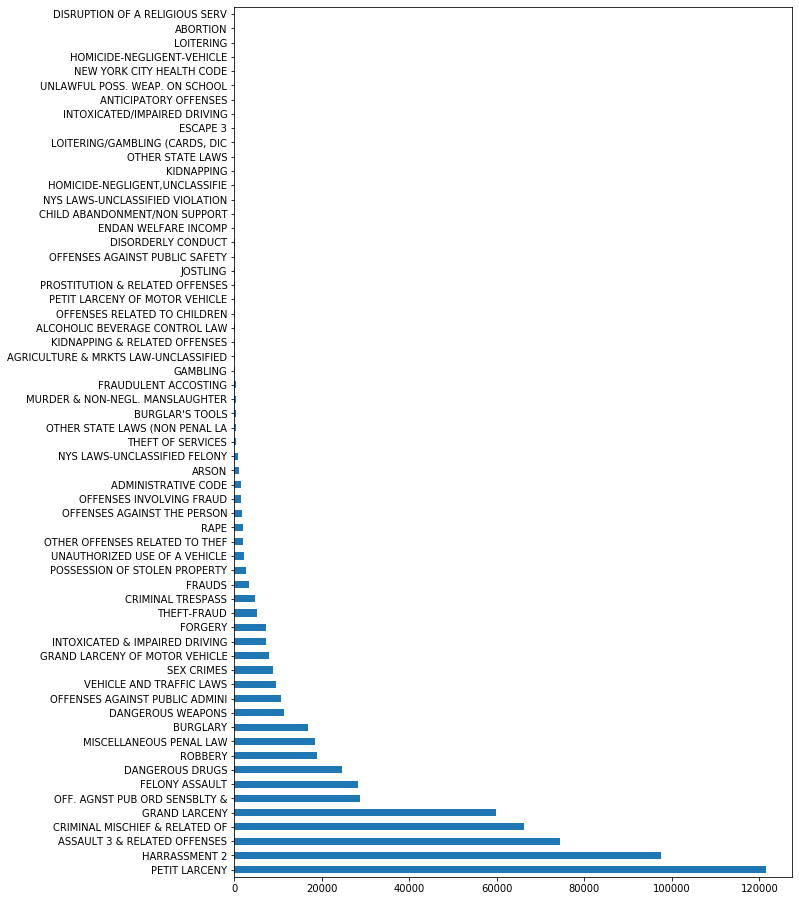

In [19]:
plt.figure(figsize=(10,16))
calls['OFNS_DESC'].value_counts().plot(kind='barh')

### 3.2 Getting a Better Plot
The plot above can be messy as it plots all offenses. Plot only the offenses that has more than 10000 calls

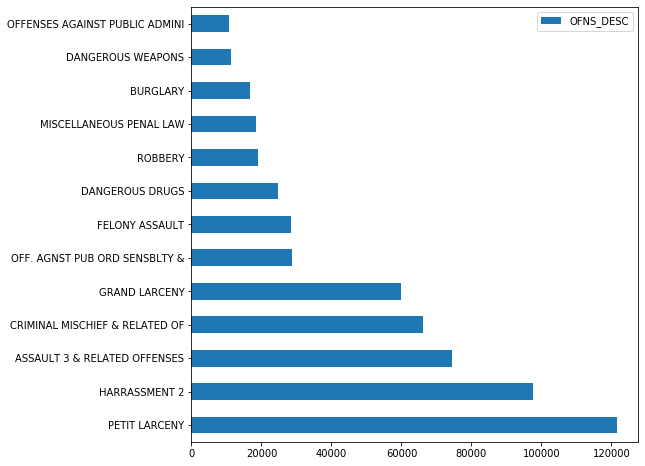

In [20]:
ax = calls['OFNS_DESC'].value_counts()[calls['OFNS_DESC'].value_counts() > 10000].to_frame()
ax.plot.barh(figsize=(8,8))

By contrast, the Seaborn library provides a specific function `countplot` built for plotting counts. It operates directly on the DataFrame itself i.e. there's no need to call `value_counts()` at all. This higher level approach makes it easier to work with. Use the y-label ("Crime Category"), x-label("Number of Calls") and title_of_plot("Number of Calls By Crime Type"

Text(0.5, 1.0, 'Number of Calls by Crime Type')

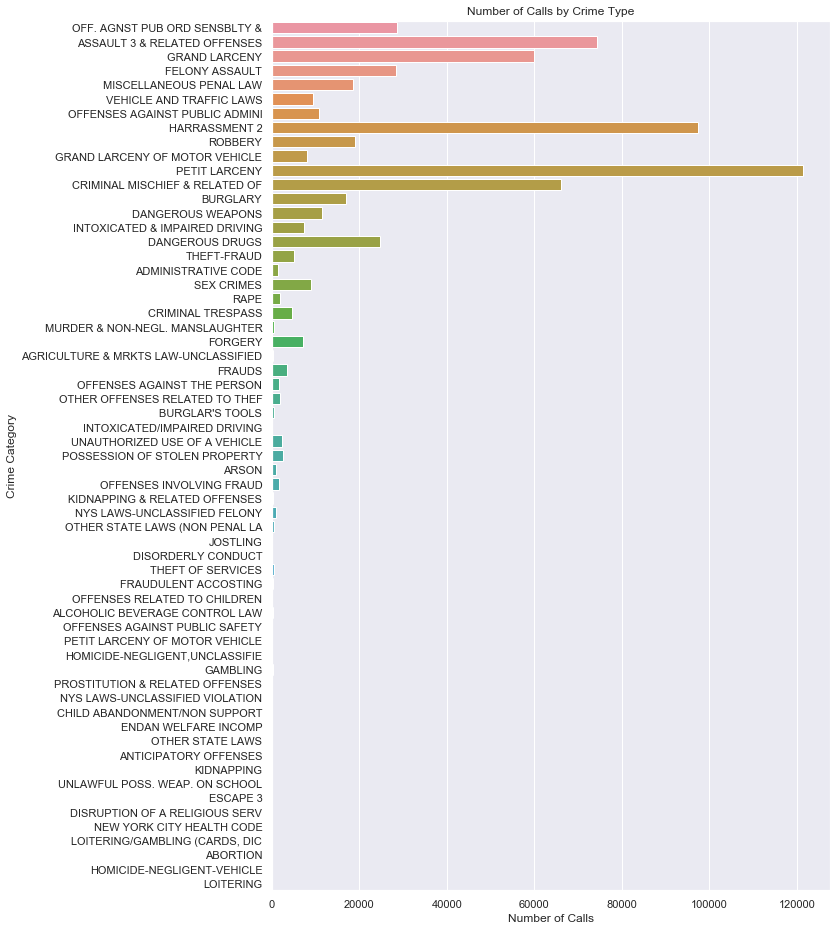

In [21]:
sns.set(style="darkgrid",rc={'figure.figsize':(10,16)})
bx=sns.countplot(data = calls, y='OFNS_DESC')
bx.set_ylabel("Crime Category")
bx.set_xlabel("Number of Calls")
bx.set_title('Number of Calls by Crime Type')

You may note that the ordering might be different for the seaborn plot (as compared to pandas plot). If we want the same ordering that we had in the pandas plot, we can use the order parameter of the `countplot` method. It takes a list of strings corresponding to the axis to be ordered. By passing the index of the `value_counts`, you can get the order you want.

Text(0.5, 1.0, 'Number of Calls by Crime Type')

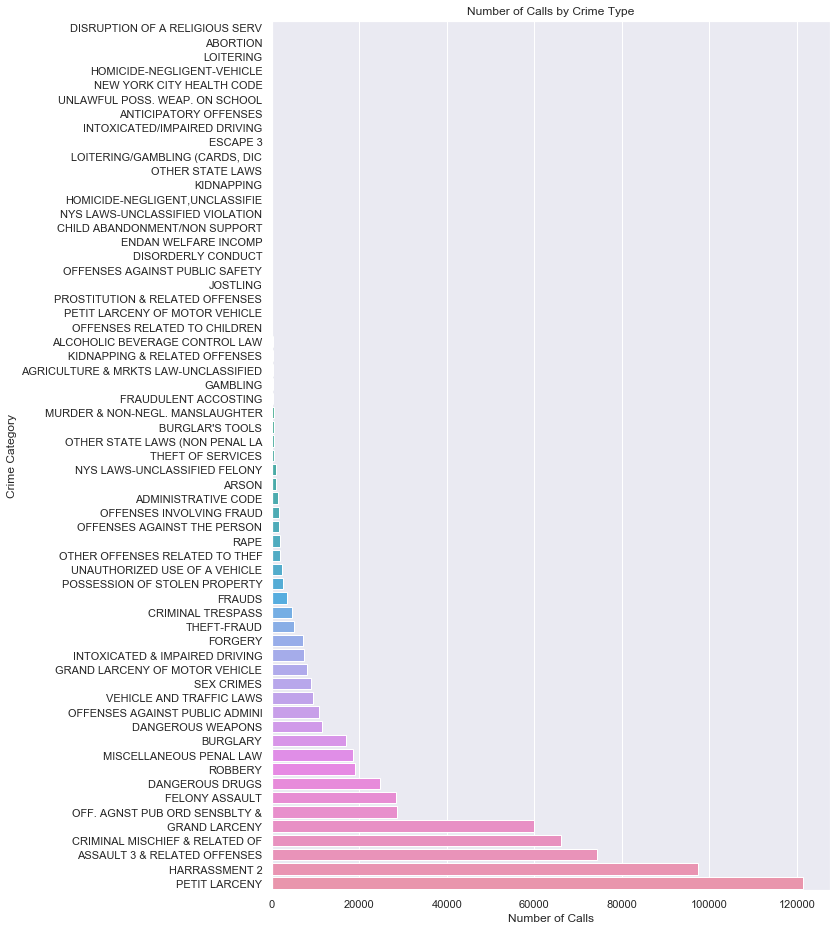

In [22]:
sns.set(style="darkgrid",rc={'figure.figsize':(10,16)})
bx=sns.countplot(data = calls, y='OFNS_DESC',order = calls['OFNS_DESC'].value_counts(ascending = True).index)
bx.set_ylabel("Crime Category")
bx.set_xlabel("Number of Calls")
bx.set_title('Number of Calls by Crime Type')

Now we have a pretty bar plot with the bars ordered by size. Though `seaborn` appears to provide a superior plot from a aesthetic point of view, the `pandas` plotting library is also good to understand. You'll get practice using both libraries in the following questions.

## An Additional Note on Plotting in Jupyter Notebooks

You may have noticed that many of our code cells involving plotting end with a semicolon (;). This prevents any extra output from the last line of the cell that we may not want to see. Try adding this to your own code in the following questions!

### 3.3 making more plots

Now it is your turn to make some more plots using `pandas` and `seaborn`. Let's start by looking at the distribution of calls over days of the week.

The CMPLNT_FR_DT field contains the date of the event. We would like to add a new column to the DataFrame that includes Day of the week (DAY_OF_WEEK) that indicates the day of the week. This can help us analyze the crimes on a specific day of the week. For example, we can answer questions such as "what day of the week that a LARSON is likely to happen in NYC?"


Add a new column `DAY_OF_WEEK` into the `calls` dataframe that has the day string (eg. 'Sunday') for the corresponding value in CMPLNT_FR_DT. For example, if the first 3 values of `CMPLNT_FR_DT` are `['01/27/2006, '01/28/2006, '01/29/2006]`, then the first 3 values of the `DAY_OF_WEEK` column should be `["Friday", "Saturday", "Sunday"]`.

**Hint:** *Try using the [Series.map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function on `calls["OFNS_DESC"]`.  Can you assign this to the new column `calls["DAY_OF_WEEK"]`?*

In [23]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
### BEGIN SOLUTION
calls['CMPLNT_FR_DT'] = pd.to_datetime(calls['CMPLNT_FR_DT'])
calls['DAY_OF_WEEK'] = calls['CMPLNT_FR_DT'].dt.weekday_name
calls[['CMPLNT_FR_DT','OFNS_DESC','DAY_OF_WEEK']]
### END SOLUTION

,CMPLNT_FR_DT,OFNS_DESC,DAY_OF_WEEK
0,2018-12-31,OFF. AGNST PUB ORD SENSBLTY &,Monday
1,2018-12-31,ASSAULT 3 & RELATED OFFENSES,Monday
2,2018-12-31,GRAND LARCENY,Monday
3,2018-12-31,FELONY ASSAULT,Monday
4,2018-12-31,ASSAULT 3 & RELATED OFFENSES,Monday
5,2018-12-31,MISCELLANEOUS PENAL LAW,Monday
6,2018-12-31,VEHICLE AND TRAFFIC LAWS,Monday
7,2018-12-31,ASSAULT 3 & RELATED OFFENSES,Monday
8,2018-12-31,OFFENSES AGAINST PUBLIC ADMINI,Monday
9,2018-12-31,HARRASSMENT 2,Monday


### 3.4 Seaborn plots

Create a `seaborn` plot that shows the number of calls for each day of the week. You may want to use of the `rotation` argument in `ax.set_xticklabels`, which rotates the labels by 90 degrees.

Text(0.5, 1.0, 'Number of Calls by The Day of Week')

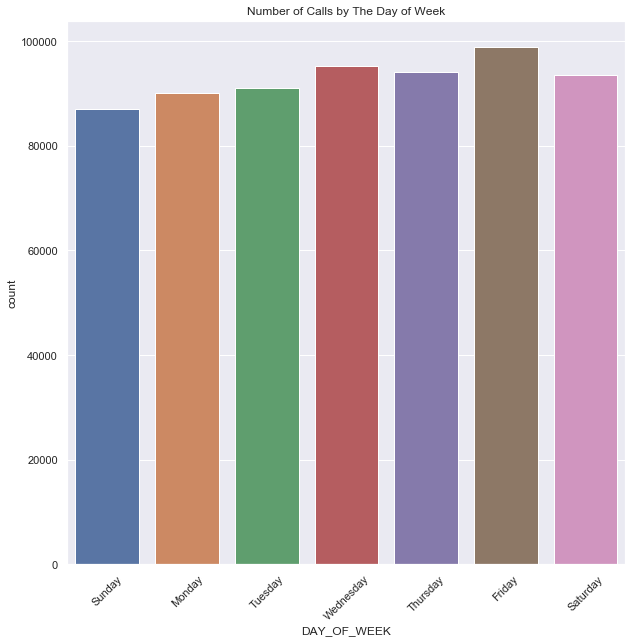

In [24]:
### BEGIN SOLUTION
sns.set(style="darkgrid",rc={'figure.figsize':(10,10)})
pic=sns.countplot(data = calls, x ='DAY_OF_WEEK', order = days)
pic.set_xticklabels(pic.get_xticklabels(), rotation=45)
pic.set_title('Number of Calls by The Day of Week')
### END SOLUTION

Now, let's make the same plot using `pandas`. Construct a vertical bar plot with the count of the number of calls (entries in the table) for each day of the week **ordered by the day of the week** (eg. `Sunday`, `Monday`, ...). Do not use `sns` for this plot. Be sure that your axes are labeled and that your plot is titled.

Text(0, 0.5, 'Count')

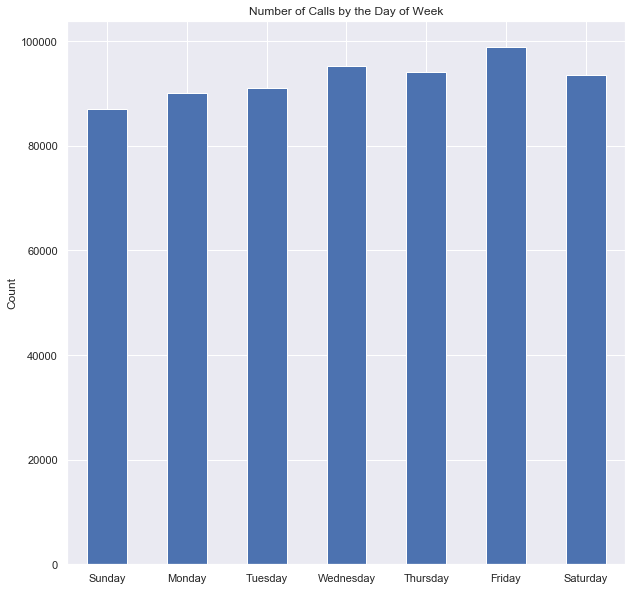

In [25]:
### BEGIN SOLUTION
pic=calls['DAY_OF_WEEK'].value_counts()[days].plot(kind='bar')
pic.set_xticklabels(pic.get_xticklabels(), rotation =0)
pic.set_title('Number of Calls by the Day of Week')
pic.set_ylabel("Count")
### END SOLUTION

## 3.5 What Day of the Week is more calls?

Is it true that weekdays generally have slightly more calls than Saturday or Sunday? What can you say about the difference?

##### BEGIN SOLUTION
Yes, it is true that all weekdays have slightly more calls than Sunday, only Monday and Tuesday have slightly less calls than Saturday, other weekdays have more calls than Saturday.
##### END SOLUTION

We can break down into some particular types of events to see their distribution. For example, let's make a bar plot for the OFNS_DESC "HARRASSMENT 2". Which day is the peak for "HARRASSMENT 2"?

This time, use `seaborn` to create a vertical bar plot of the number of total noise violations reported on each day of the week, again ordered by the days of the week starting with Sunday. Do not use `pandas` to plot.


Text(0.5, 1.0, 'Number of Calls by The Day of Week')

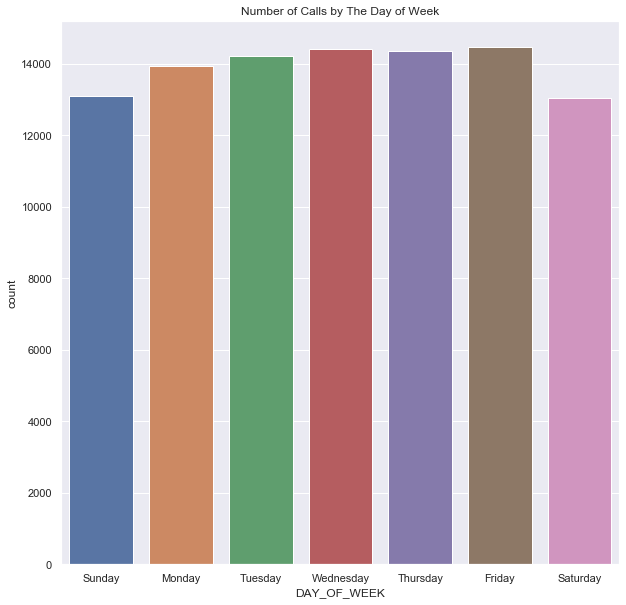

In [26]:
df = calls[calls['OFNS_DESC']=='HARRASSMENT 2']
pic=sns.countplot(data = df, x ='DAY_OF_WEEK', order = days)
pic.set_xticklabels(pic.get_xticklabels(), rotation=0)
pic.set_title('Number of Calls by The Day of Week')


### 3.6 

Do you see anything interesting about the distribution of HARRASSMENT 2 calls over a week?
##### BEGIN SOLUTION
In general weekdays have slightly more calls about harrassement than Saturday and Sunday. Saturday has the lowest probability that the crime "HARRASSMENT 2" can happen.
##### END SOLUTION

### 3.7 More Plots

Let's look at a similar distribution but for a crime we have much more calls data about. In the cell below, create the same plot as you did in previous questions, but now looking at instances of the OFNS_DESC "BURGLARY" (instead of "HARRASSMENT 2"). Use either `pandas` or `seaborn` plotting as you desire.

Text(0.5, 1.0, 'Number of Calls by The Day of Week')

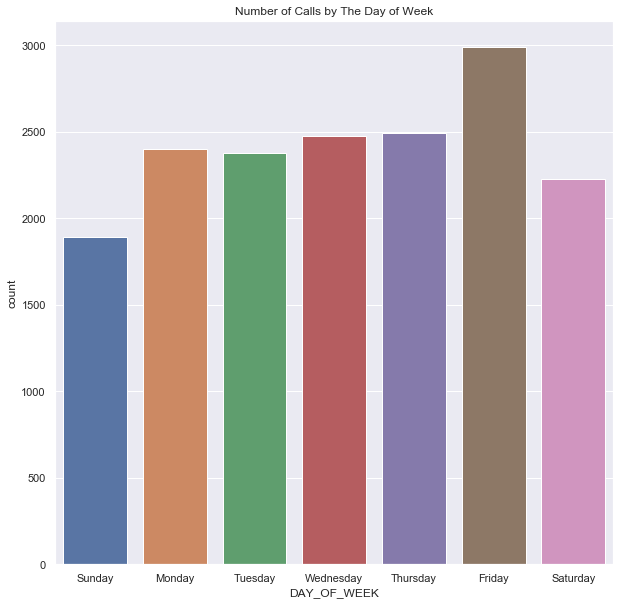

In [28]:
df_B = calls[calls['OFNS_DESC']=='BURGLARY']

pic=sns.countplot(data = df_B, x ='DAY_OF_WEEK', order = days)
pic.set_xticklabels(pic.get_xticklabels(), rotation=0)
pic.set_title('Number of Calls by The Day of Week')

### 3.8 time of events

Now let's look at the CMPLNT_TO_TM column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` dataframe. You should save the hour as an `int`. Then plot the frequency of each hour in the table (i.e., `value_counts()`) sorted by the hour of the day (i.e., `sort_index()`).

You will want to look into how to use:

* [Series.str.slice](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.slice.html#pandas.Series.str.slice) to select the substring.
* [Series.astype](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html) to change the type.


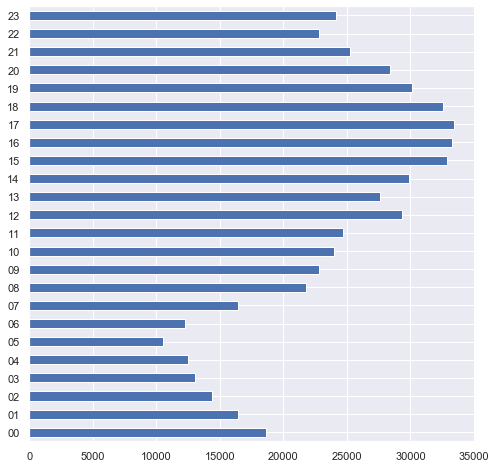

In [29]:
s = calls["CMPLNT_TO_TM"].str.slice(stop=2).value_counts().sort_index()
s.plot.barh(figsize=(8,8))

Create a pandas bar plot showing the number of BURGLARY crimes committed at each hour of the day. Use the labels
* ax.set_xlabel("Hour of the Day")
* ax.set_ylabel("Number of Calls")
* ax.set_title("Number of Calls Reporting Fraud For Each Day of the Week");

Text(0.5, 1.0, 'Number of Calls Reporting Fraud For Each Day of the Week')

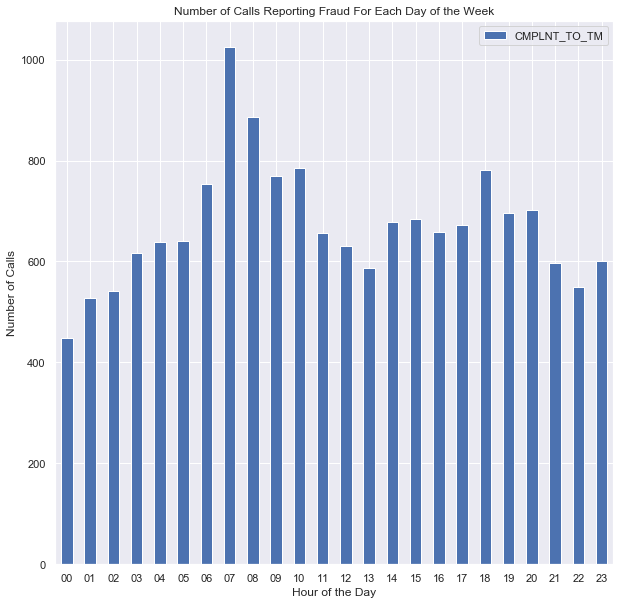

In [30]:
A = df_B["CMPLNT_TO_TM"].str.slice(stop=2).value_counts().sort_index().to_frame()
ax = A.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation =0)
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls Reporting Fraud For Each Day of the Week")

### 3.9 More plots

In the cell below, create a seaborn plot of the same data. Again, make sure you provide axes labels and a title for your plot.

Text(0, 0.5, 'Number of Calls')

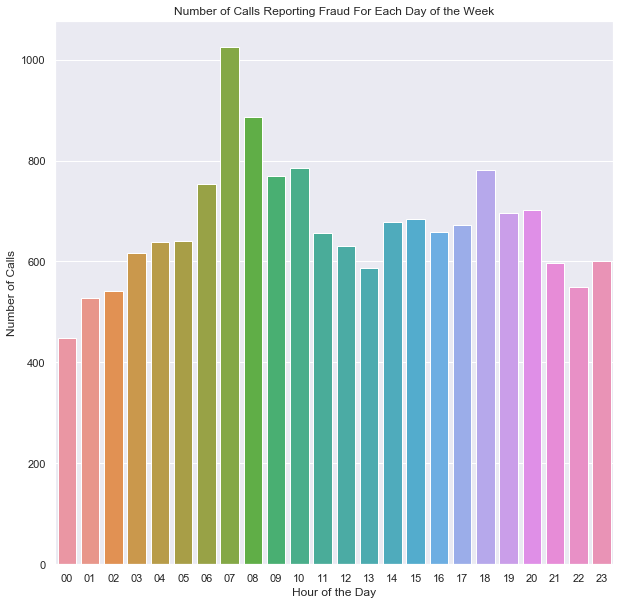

In [31]:
pic = sns.countplot(data = df_B, x = df_B["CMPLNT_TO_TM"].str.slice(stop=2), order = A.index)
pic.set_title('Number of Calls Reporting Fraud For Each Day of the Week')
pic.set_xlabel("Hour of the Day")
pic.set_ylabel("Number of Calls")

### 3.8 Spike in burglary?

According to your plots, is there a spike in calls reporting BURGLARY at any particular time? If so, Do you trust that this spike is legitimate, or could there be an issue with our data? Explain your reasoning in 1-2 sentences below.

#### BEGIN SOLUTION
Accodring to the plots, we can see that a spike in calls reporting BURGLARY usually happens in the morning about 7-8 AM. This is reasonable beccause BURGLARIES usually happens during night-time while people were sleeping. Until the morning, the victim families or their neightbors could notice that. Therefore, the calls for reporting BURGLARY usually happens in the morning. 


#### END SOLUTION

In the cell below, we generate a boxplot which examines the hour of day of each crime broken down by the `OFNS_DESC` value.  To construct this plot we used the [DataFrame.boxplot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html) documentation.

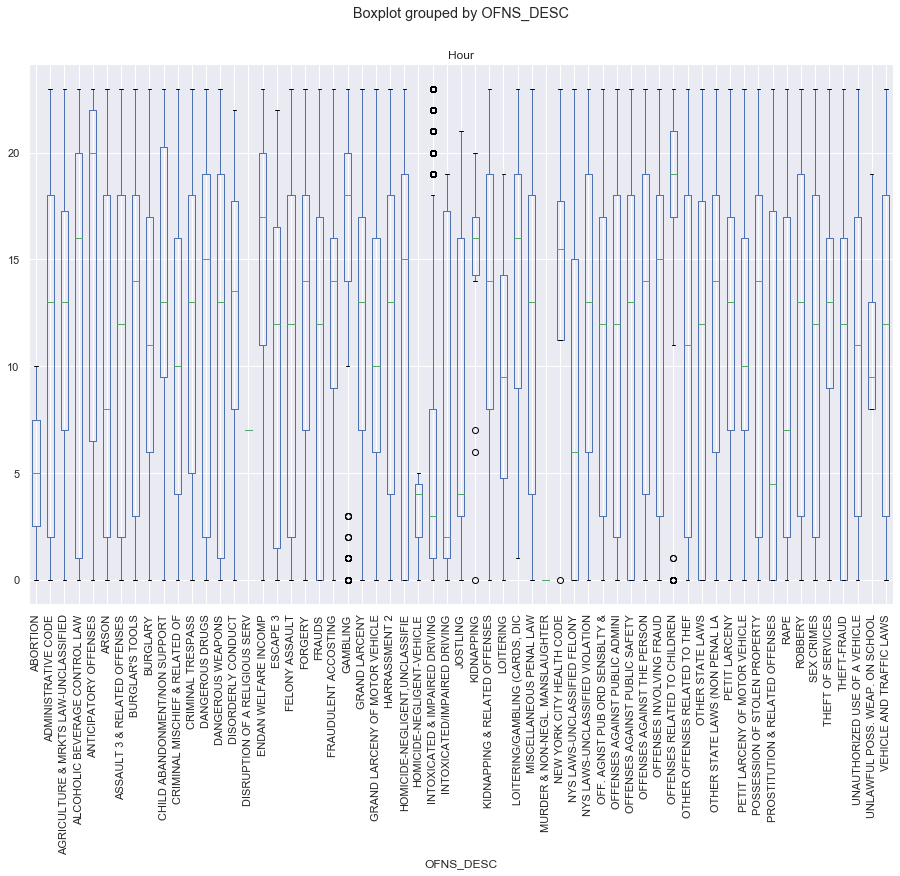

In [64]:
calls['Hour']= calls["CMPLNT_TO_TM"].str.slice(stop=2).fillna(0).astype('int64')

boxplot = calls.boxplot(column='Hour', by='OFNS_DESC',rot=90,figsize=(15,10))


While the pandas boxplot is informative, we can use seaborn to create a more visually-appealing plot. Using seaborn, regenerate a better box plot. See either the textbook (https://www.textbook.ds100.org/ch/06/viz_quantitative.html) or the [seaborn boxplot documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

Looking at your plot, which crime type appears to have the largest interquartile range? Put your results into `answer` as a string.

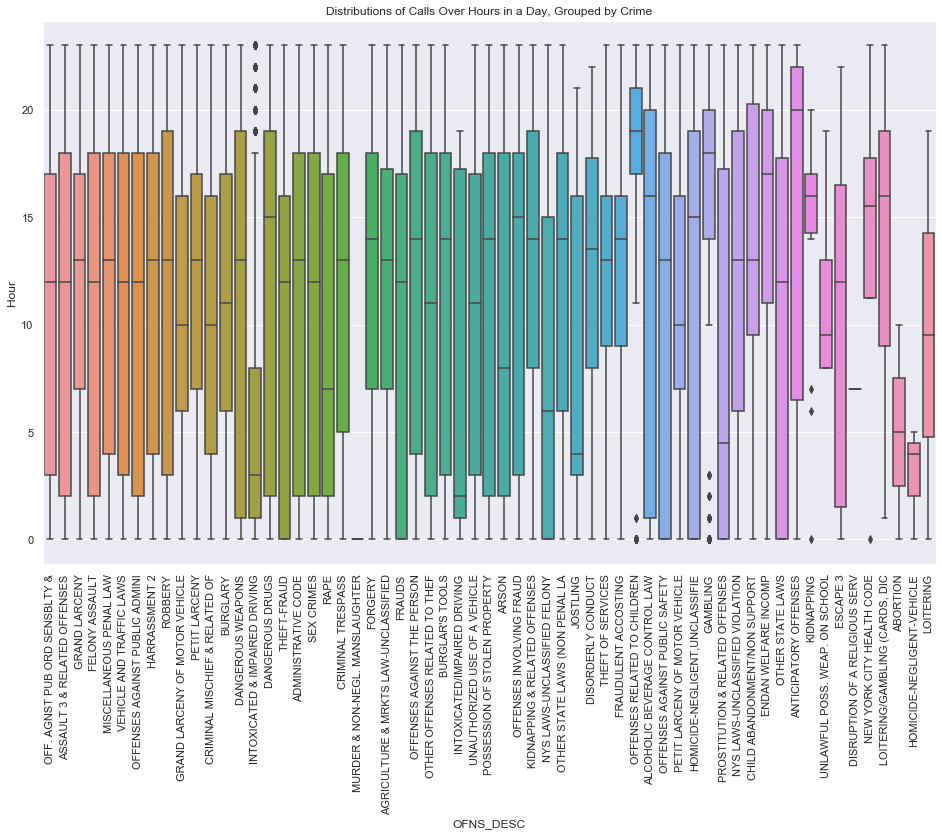

In [69]:
# Todo: Make a boxplot with seaborn
### BEGIN SOLUTION
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x="OFNS_DESC", y="Hour", data=calls)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title("Distributions of Calls Over Hours in a Day, Grouped by Crime");
answer = "ALCOHOLIC BEVERAGE CONTROL LAW"
### END SOLUTION

### 3.9 - Visualization of crimes on a Map of NYC
finally we attempt to visualize the crimes committed in NYC on a Map. First we need to installing some mapping software. run the cell below to install folium package for mapping software.

In [81]:
!pip install --upgrade folium

     |████████████████████████████████| 92kB 2.9MB/s eta 0:00:011


In [93]:
df_B

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,DAY_OF_WEEK
28,822444875,2018-12-31,14:00:00,12/31/2018,14:05:00,79.0,12/31/2018,107,BURGLARY,231.0,...,NaN,40.680689,-73.943382,"(40.680689426, -73.943382107)",PATROL BORO BKLYN NORTH,NaN,25-44,ASIAN / PACIFIC ISLANDER,M,Monday
44,618857774,2018-12-31,04:18:00,12/31/2018,04:22:00,14.0,12/31/2018,107,BURGLARY,213.0,...,NaN,40.756266,-73.990501,"(40.756266207, -73.990501248)",PATROL BORO MAN SOUTH,NaN,UNKNOWN,UNKNOWN,D,Monday
125,861311307,2018-12-31,19:45:00,12/31/2018,19:50:00,120.0,12/31/2018,107,BURGLARY,223.0,...,NaN,40.621006,-74.098039,"(40.621006434, -74.098038517)",PATROL BORO STATEN ISLAND,NaN,25-44,BLACK,F,Monday
150,778692024,2018-12-31,00:20:00,12/31/2018,03:30:00,69.0,12/31/2018,107,BURGLARY,213.0,...,NaN,40.635766,-73.912896,"(40.635765752, -73.912895753)",PATROL BORO BKLYN SOUTH,NaN,UNKNOWN,UNKNOWN,D,Monday
267,908148337,2018-12-31,02:50:00,NaN,NaN,90.0,12/31/2018,107,BURGLARY,223.0,...,NaN,40.704207,-73.950738,"(40.704207255, -73.950737797)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F,Monday
274,683644266,2018-12-31,12:00:00,12/31/2018,12:15:00,71.0,12/31/2018,107,BURGLARY,221.0,...,NaN,40.666222,-73.949454,"(40.666221793, -73.949453765)",PATROL BORO BKLYN SOUTH,NaN,18-24,BLACK,F,Monday
325,529224142,2018-12-31,01:00:00,12/31/2018,06:00:00,107.0,12/31/2018,107,BURGLARY,223.0,...,NaN,40.735323,-73.823354,"(40.735323172, -73.823353841)",PATROL BORO QUEENS SOUTH,NaN,25-44,WHITE,F,Monday
371,269702474,2018-12-31,21:03:00,12/31/2018,22:30:00,110.0,12/31/2018,107,BURGLARY,213.0,...,NaN,40.759961,-73.844734,"(40.759960697, -73.844733763)",PATROL BORO QUEENS NORTH,NaN,UNKNOWN,UNKNOWN,D,Monday
398,852344244,2018-12-31,04:55:00,12/31/2018,05:00:00,34.0,12/31/2018,107,BURGLARY,223.0,...,NaN,40.853993,-73.934884,"(40.853993366, -73.934884396)",PATROL BORO MAN NORTH,NaN,25-44,WHITE,F,Monday
406,679870027,2018-12-31,04:30:00,12/31/2018,04:35:00,34.0,12/31/2018,107,BURGLARY,223.0,...,NaN,40.853659,-73.935745,"(40.853658996, -73.935745043)",PATROL BORO MAN NORTH,NaN,45-64,WHITE,F,Monday


In [104]:
### Plot the maps for BURGLARY in NYC
### if it takes too much time or map does not show up, try plotting a subset of the data set of for a specific crime
## location get from https://www.latlong.net
### BEGIN SOLUTION
import folium
from folium import plugins
from folium.plugins import HeatMap
m = folium.Map(location=[40.713051,-74.007233],zoom_start = 10)
folium.Marker(location=[40.837891, -73.868032], popup='THE BRONX').add_to(m)
folium.Marker(location=[40.643501, -74.076202], popup='STATEN ISLAND').add_to(m)
df_B['Latitude'] = df_B['Latitude'].astype(float)
df_B['Longitude'] = df_B['Longitude'].astype(float)
heat_df = df_B[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])
# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(m)

# Display the map
m
### END SOLUTION

/Users/hongpinglin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/hongpinglin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


## Congratulations !!!

<div class="alert alert-block alert-info">
<h2>Submission Instructions</h2> 
<b> File Name:</b> Please name the file as your_section_your_netID_Lab3.jpynb<br>
<b> Submit To: </b> Canvas &rarr; Assignments &rarr; Lab3 <br>
<b>Warning:</b> Failure to follow directions may result in loss of points.<br>
</div>

Credits: Josh Hug, and Berkeley Data Science Group for their contributions to the original version.